In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch 
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from loop_train_berts import (
    BertClassifier,
    preprocessing_for_bert,
    bert_predict
)

from utils import plot_roc

batch_size=8

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

There are 2 GPU(s) available.
Device name: GeForce RTX 2080 Ti


In [2]:
positive = pd.read_csv('data/positive.tsv', sep='\t', index_col=0)
positive['target'] = 1
negative = pd.read_csv('data/negative.tsv', sep='\t', index_col=0)
negative['target'] = 0

In [3]:
data = positive.append(negative)

In [4]:
data['concat'] = data.Title.map(str) + " " + data.Abstract.fillna(' ').map(str)

In [5]:
data['bert'] = data['concat'].apply(lambda x: x.lower())

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.bert, data.target, test_size=0.1, random_state=42)

In [7]:
prefix = 'train-'
models = ['allenai-scibert_scivocab_uncased.pkl', 
          'dmis-lab-biobert-v1.1.pkl', 
          'allenai-biomed_roberta_base.pkl', 
          'emilyalsentzer-Bio_ClinicalBERT.pkl', 
          'microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext.pkl']
tokenizers = ['allenai/scibert_scivocab_uncased', 
              'dmis-lab/biobert-v1.1', 
              'allenai/biomed_roberta_base', 
              'emilyalsentzer/Bio_ClinicalBERT', 
              'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext']
names = ['scibert', 
         'biobert', 
         'biomed-roberta', 
         'bioclinical-bert', 
         'pubmed-bert']

In [8]:
probs_df = pd.DataFrame()

for name, model, tokenizer in zip(names, models, tokenizers):

    tokenizer = AutoTokenizer.from_pretrained(tokenizer, do_lower_case=True)

    test_inputs, test_masks = preprocessing_for_bert(tokenizer, X_test)
    test_labels = torch.tensor(y_test.values)

    batch_size = 8

    test_data = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size, num_workers=1)

    bert_classifier = torch.load('./models/' + prefix + model)
    
    probs = bert_predict(bert_classifier, test_dataloader, device)
    y_pred = np.where(probs[:, 1] >= 0.5, 1, 0)
    
    probs_df[name] = probs[:, 1]
    
    print(name, accuracy_score(y_test, y_pred))

scibert 0.9767769176636172
biobert 0.9774806474313863
biomed-roberta 0.9866291344123856
bioclinical-bert 0.9746657283603096
pubmed-bert 0.9795918367346939


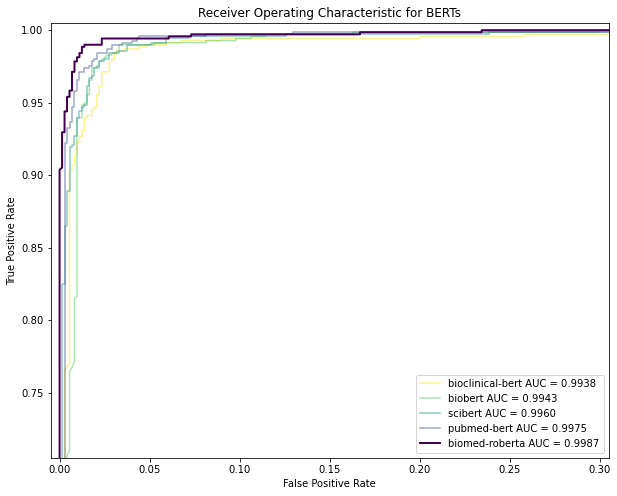

In [9]:
plot_roc(probs_df, y_test)

In [10]:
val = pd.read_csv('./data/Validation.tsv', sep='\t')
val['concat'] = val.Title.map(str) + " " + val.Abstract.fillna(' ').map(str)
val['bert'] = val['concat'].apply(lambda x: x.lower())

In [12]:
tokenizer = AutoTokenizer.from_pretrained('allenai/biomed_roberta_base', do_lower_case=True)

val_inputs, val_masks = preprocessing_for_bert(tokenizer, val.bert)

val_data = TensorDataset(val_inputs, val_masks)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size, num_workers=1)

bert_classifier = torch.load('./models/' + 'full-allenai-biomed_roberta_base.pkl')

probs = bert_predict(bert_classifier, val_dataloader, device)

In [13]:
preds = np.where(probs[:, 1] > 0.5, 1, 0)

In [14]:
pd.Series(preds).to_csv('submission-1.csv', index=False)